# NYC Congestion Pricing Impact on PM2.5 

This notebook analyzes the effects of NYC's congestion pricing using PM2.5 data from 7 PurpleAir sensors within the pricing zone.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:

folder_path = "data/purple_air_sensor/"

# Get all CSV file paths in the folder
file_paths = glob.glob(folder_path + "*.csv")

print(f"Found {len(file_paths)} sensor files.")

Found 7 sensor files.


## Load Sensor Data
Update the file paths if needed to point to your 7 CSV files.

In [5]:
# Load each file, extract time and calibrated PM2.5, store in a list
dfs = []

for path in file_paths:
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["time_stamp"])
    df = df.rename(columns={"pm2.5_alt|3.4": "pm25"})
    dfs.append(df[["time", "pm25", "temperature", "humidity"]])

print(f"Loaded and cleaned {len(dfs)} dataframes.")

Loaded and cleaned 7 dataframes.


## Merge and Aggregate PM2.5 Across All Sensors

In [6]:
merged_df = dfs[0]
for i in range(1, len(dfs)):
    merged_df = pd.merge(merged_df, dfs[i], on="time", how="outer", suffixes=('', f'_{i}'))

# Compute averages across all sensors
pm25_columns = [col for col in merged_df.columns if "pm25" in col]
temp_columns = [col for col in merged_df.columns if "temperature" in col]
humidity_columns = [col for col in merged_df.columns if "humidity" in col]

merged_df["pm25_avg"] = merged_df[pm25_columns].mean(axis=1)
merged_df["temp_avg"] = merged_df[temp_columns].mean(axis=1)
merged_df["humidity_avg"] = merged_df[humidity_columns].mean(axis=1)

# Sort by time
merged_df = merged_df.sort_values("time")


merged_df[["time", "pm25_avg", "temp_avg", "humidity_avg"]].head()

,time,pm25_avg,temp_avg,humidity_avg
0,2024-01-01 00:00:00+00:00,8.433333,61.833333,29.333333
1,2024-01-01 06:00:00+00:00,10.800000,61.500000,32.500000
2,2024-01-01 12:00:00+00:00,10.050000,61.500000,36.000000
3,2024-01-01 18:00:00+00:00,8.416667,63.000000,30.666667
4,2024-01-02 00:00:00+00:00,4.666667,57.500000,33.500000


## Plot PM2.5 Time Series

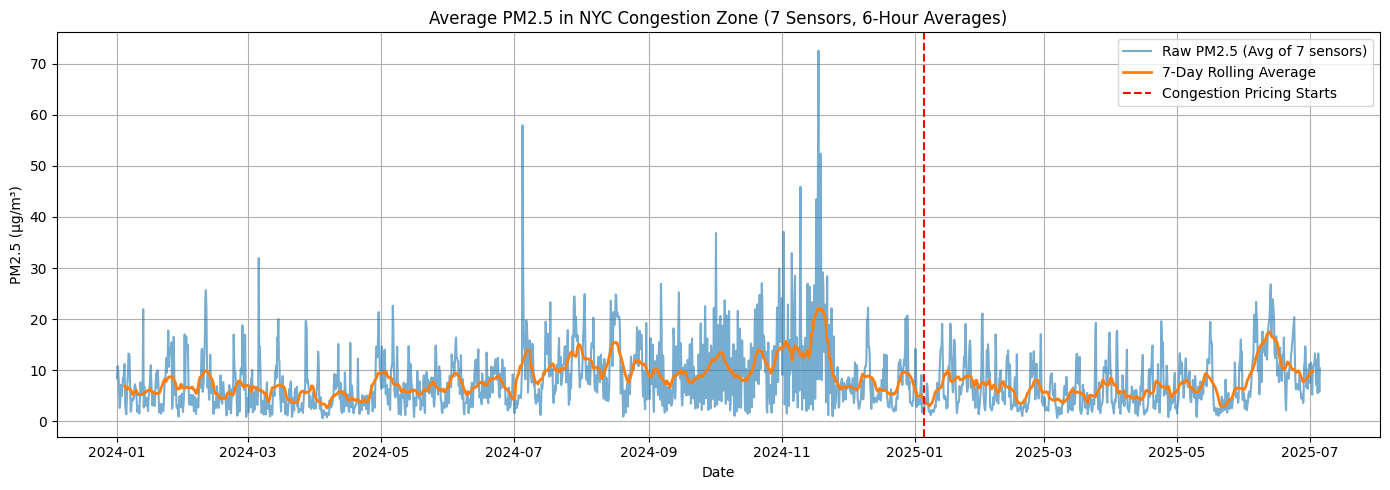

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(merged_df["time"], merged_df["pm25_avg"], label="Raw PM2.5 (Avg of 7 sensors)", alpha=0.6)

merged_df["pm25_avg_smooth"] = merged_df["pm25_avg"].rolling(window=28, center=True).mean()
plt.plot(merged_df["time"], merged_df["pm25_avg_smooth"], label="7-Day Rolling Average", linewidth=2)

plt.axvline(pd.Timestamp("2025-01-05"), color="red", linestyle="--", label="Congestion Pricing Starts")

plt.title("Average PM2.5 in NYC Congestion Zone (7 Sensors, 6-Hour Averages)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
cutoff_date = pd.Timestamp("2024-06-30",tz="UTC")

# Before and after subsets
before = merged_df[merged_df["time"] < cutoff_date]
after = merged_df[merged_df["time"] >= cutoff_date]

# Summary statistics
print("PM2.5 Summary BEFORE Congestion Pricing:")
print(before["pm25_avg"].describe())

print("\nPM2.5 Summary AFTER Congestion Pricing:")
print(after["pm25_avg"].describe())

PM2.5 Summary BEFORE Congestion Pricing:
count    724.000000
mean       6.313356
std        4.169394
min        0.566667
25%        3.275000
50%        5.308333
75%        8.070833
max       31.950000
Name: pm25_avg, dtype: float64

PM2.5 Summary AFTER Congestion Pricing:
count    1484.000000
mean        8.807731
std         6.487102
min         0.657143
25%         4.129167
50%         7.273333
75%        11.825000
max        72.550000
Name: pm25_avg, dtype: float64


In [9]:
from scipy.stats import ttest_ind

# Welch's t-test (doesn't assume equal variances)
t_stat, p_value = ttest_ind(before["pm25_avg"], after["pm25_avg"], equal_var=False)

print("Welch's t-test Results:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print(" Statistically significant difference (p < 0.05)")
else:
    print("No statistically significant difference (p ≥ 0.05)")

Welch's t-test Results:
T-statistic: -10.900
P-value: 0.0000
 Statistically significant difference (p < 0.05)


In [12]:
from prophet import Prophet

In [39]:
prophet_df = merged_df[["time", "pm25_avg"]].copy()
prophet_df["ds"] = prophet_df["time"].dt.tz_localize(None)
prophet_df = prophet_df.rename(columns={"pm25_avg": "y"})

prophet_df = prophet_df[["ds", "y"]]  # Keep only Prophet-required columns
prophet_df.head()


,ds,y
0,2024-01-01 00:00:00,8.433333
1,2024-01-01 06:00:00,10.800000
2,2024-01-01 12:00:00,10.050000
3,2024-01-01 18:00:00,8.416667
4,2024-01-02 00:00:00,4.666667


In [41]:
prophet_df["congestion_pricing"] = (prophet_df["ds"] >= pd.Timestamp("2024-06-30")).astype(int)
# Initialize Prophet with regressor
model = Prophet(daily_seasonality=True)
model.add_regressor("congestion_pricing")

# Fit the model
model.fit(prophet_df)

17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:08 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Create future dataframe (6-hour intervals until Dec 31, 2025)
future = model.make_future_dataframe(periods=4 * ((pd.Timestamp("2026-12-31") - prophet_df["ds"].max()).days), freq="6h")

# Add policy regressor to future data
future["congestion_pricing"] = (future["ds"] >= pd.Timestamp("2024-06-30")).astype(int)

# Forecast
forecast = model.predict(future)

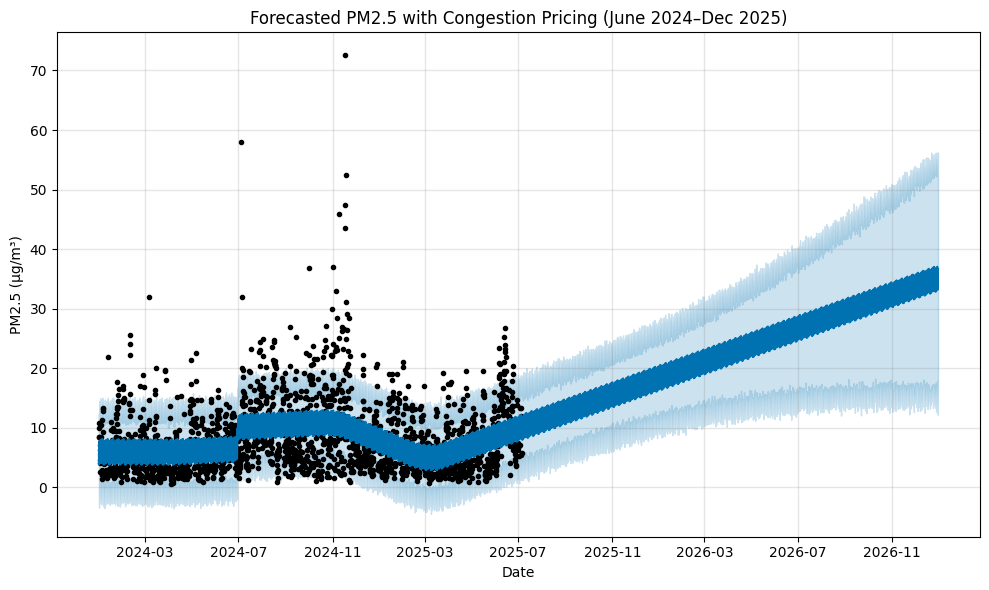

In [43]:
fig = model.plot(forecast)
plt.title("Forecasted PM2.5 with Congestion Pricing (June 2024–Dec 2025)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd

# Downsample to daily averages and strip timezone
daily_df = merged_df.copy()
daily_df["ds"] = daily_df["time"].dt.tz_localize(None).dt.floor("D")

# Group by day and average all relevant columns
daily_df = daily_df.groupby("ds", as_index=False)[["pm25_avg", "temp_avg", "humidity_avg"]].mean()

# Set datetime index and ensure daily frequency
daily_df = daily_df.set_index("ds").asfreq("D")

# Add congestion pricing regressor (policy started Jan 5, 2025)
daily_df["congestion_pricing"] = (daily_df.index >= pd.Timestamp("2025-01-05")).astype(int)

daily_df.head()
daily_df.head()

,pm25_avg,temp_avg,humidity_avg,congestion_pricing
ds,,,,
2024-01-01,9.425000,61.958333,32.125000,0
2024-01-02,4.612500,56.208333,31.250000,0
2024-01-03,6.716667,59.041667,29.500000,0
2024-01-04,8.154167,59.750000,29.083333,0
2024-01-05,3.779167,53.166667,26.500000,0


In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Drop any NaNs to avoid errors
arimax_data = daily_df.dropna()

# Define target and regressors
y = arimax_data["pm25_avg"]
X = arimax_data[["congestion_pricing", "temp_avg", "humidity_avg"]]

# Fit ARIMAX model
model = SARIMAX(y, order=(1, 0, 1), exog=X)
results = model.fit(disp=False)

# Summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               pm25_avg   No. Observations:                  552
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1484.184
Date:                Sun, 06 Jul 2025   AIC                           2980.368
Time:                        17:40:13   BIC                           3006.250
Sample:                    01-01-2024   HQIC                          2990.481
                         - 07-05-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
congestion_pricing    -1.2582      0.896     -1.404      0.160      -3.014       0.498
temp_avg               0.0722      0.015      4.788      0.000       0.043       0.102
humidity_avg        

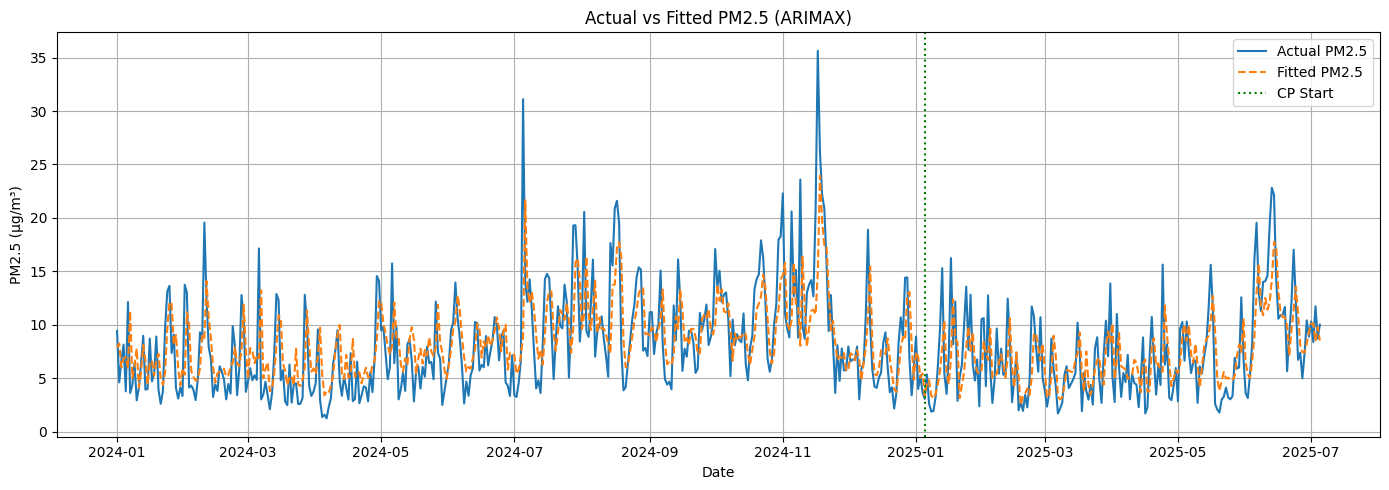

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y.index, y, label="Actual PM2.5")
plt.plot(y.index, results.fittedvalues, label="Fitted PM2.5", linestyle='--')
plt.axvline(pd.Timestamp("2025-01-05"), color="green", linestyle=":", label="CP Start")
plt.title("Actual vs Fitted PM2.5 (ARIMAX)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretation
	•	The model estimates that congestion pricing reduced PM2.5 by ~1.26 µg/m³, controlling for temperature and humidity
	•	But p = 0.16, so we cannot reject the null hypothesis (i.e., there’s no strong statistical evidence of a change)
	•	Temperature and humidity are clearly significant drivers of PM2.5 variation

⸻

 Why might CP be insignificant here?
	1.	Short post-policy window: Only ~6 months of data since Jan 2025
	2.	Seasonal effects: CP started mid-winter, when pollution is already elevated
	3.	Policy lag: Behavior (traffic volume) may take weeks/months to change
	4.	Non-vehicular PM2.5 sources: Heating, cooking, windborne dust aren’t affected by tolling